### **Mount Google Drive/Parent Directory**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### **Install and Import Libraries**

In [ ]:
import random
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans
from scipy.ndimage.filters import median_filter
from skimage.morphology import disk
import seaborn as sns
import pickle
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive


import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
import random
import torch
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from scipy.cluster.vq import vq
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from scipy.stats import kurtosis, skew
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from sklearn.metrics import classification_report, balanced_accuracy_score, cohen_kappa_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import kurtosis, skew
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import pickle
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive
from pathlib import Path
from sklearn.utils import shuffle

### **Dataset Loading**

In [ ]:
# ############ Working With Smaller Datset ############
# ###################### RUN ONCE #########################
# ## Collecting the path and labels from the dataset
# train_nevus= sorted(glob(os.path.join(train_directory, "nevus", "*.jpg")))
# train_others= sorted(glob(os.path.join(train_directory, "others","*.jpg")))
# tags_nevus_train = []
# tags_others_train = []
# tags_train = []
# labels_nevus = []
# labels_others = []
# labels_train = []
# routes_train = []
# for i in range(len(train_nevus)):
#   tags_nevus_train.append(train_nevus[i][-12:])
#   labels_nevus.append(0)
# for i in range(len(train_others)):
#   tags_others_train.append(train_others[i][-12:])
#   labels_others.append(1)

# ## Combining the tags and labels from all the classes
# tags_train = tags_nevus_train[1:1500] + tags_others_train[1:1500]
# labels_train= labels_nevus[1:1500] + labels_others[1:1500]
# routes_train = train_nevus[1:1500] + train_others[1:1500]

# ## Writing to CSV File
# training_set = pd.DataFrame.from_dict({'Image Tag':tags_train, 'Label': labels_train, 'Image Route': routes_train})
# training_set = training_set.sample(frac=1,random_state=42).reset_index(drop=True)
# training_set.to_csv(input_directory+'/training_set3000.csv')

In [ ]:
def dataExtraction(directory, vocab):

  scc= sorted(glob(os.path.join(directory, "scc", "*.jpg")))
  mel = sorted(glob(os.path.join(directory, "mel", "*.jpg")))
  bcc = sorted(glob(os.path.join(directory, "bcc", "*.jpg")))
  if(vocab==True):
    scc = scc[0:100]
    mel = mel[0:100]
    bcc = bcc[0:100]
  tags_scc = []
  tags_mel = []
  tags_bcc = []
  tags_total = []
  labels_scc = []
  labels_mel = []
  labels_bcc = []
  labels_total = []
  routes_total = []
  for i in range(len(mel)):
    tags_mel.append(mel[i][-12:])
    labels_mel.append(0)
  for i in range(len(bcc)):
    tags_bcc.append(bcc[i][-12:])
    labels_bcc.append(1)
  for i in range(len(scc)):
    tags_scc.append(scc[i][-12:])
    labels_scc.append(2)
  ## Combining the tags and labels from all the classes
  tags_total = tags_scc + tags_mel + tags_bcc
  labels_total= labels_scc + labels_mel + labels_bcc
  routes_total = scc + mel + bcc

  return tags_total, labels_total, routes_total

In [ ]:
# Directories
input_directory = '/content/drive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem'
train_directory = input_directory+'/train' 
val_directory = input_directory+'/val'

**Training Dataset**

In [ ]:
## Writing to CSV File
tags_train, labels_train, routes_train = dataExtraction(train_directory, vocab=False)
training_set= pd.DataFrame.from_dict({'Image Tag':tags_train, 'Label': labels_train, 'Image Route': routes_train})
training_set= training_set.sample(frac=1,random_state=42).reset_index(drop=True)
training_set.to_csv(input_directory+'/Data/training_set.csv')

In [ ]:
## Writing to CSV File For Vocabulary
vocab_tags_train, vocab_labels_train, vocab_routes_train = dataExtraction(train_directory, vocab=True)
vocab_training_set= pd.DataFrame.from_dict({'Image Tag':vocab_tags_train, 'Label': vocab_labels_train, 'Image Route': vocab_routes_train})
vocab_training_set= vocab_training_set.sample(frac=1,random_state=42).reset_index(drop=True)
vocab_training_set.to_csv(input_directory+'/Data/vocab_training_set.csv')

**Validation Set**

In [ ]:
## Writing to CSV File
tags_val, labels_val, routes_val = dataExtraction(val_directory, vocab=False)
validation_set= pd.DataFrame.from_dict({'Image Tag':tags_val, 'Label': labels_val, 'Image Route': routes_val})
validation_set= validation_set.sample(frac=1,random_state=42).reset_index(drop=True)
validation_set.to_csv(input_directory+'/Data/validation_set.csv')

In [ ]:
## Checking
print(len(training_set))
print(len(validation_set))
print(len(vocab_training_set))

8058
1270
300


### **Vocabulary Building : SIFT/BoW**

In [ ]:
training_csv_path = input_directory + '/Data/training_set.csv'
validation_csv_path =  input_directory + '/Data/validation_set.csv'
vocab_csv_path = input_directory + '/Data/vocab_training_set.csv'
training_dataframe = pd.read_csv(training_csv_path)
validation_dataframe = pd.read_csv(validation_csv_path)
vocab_dataframe = pd.read_csv(vocab_csv_path)
training_images_routes= training_dataframe['Image Route'].to_numpy()
validation_images_routes= validation_dataframe['Image Route'].to_numpy()
vocab_images_routes= vocab_dataframe['Image Route'].to_numpy()

In [ ]:
## Test Purpose
print(len(training_images_routes))
print(len(validation_images_routes))
print(len(vocab_images_routes))

7097
1270
300


**Getting the Descriptors**

In [ ]:
def FeatureExtractionSIFT(image_routes):
  descriptors_list = []
  for i in image_routes:
    #input image
    image_read = cv2.imread(i)
    dim = (512, 512)
    # resize image
    image_resized =  cv2.resize(image_read, dim, interpolation = cv2.INTER_AREA)
    # cv2_imshow(image_resized)
    image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    # cv2_imshow(image_gray)


    # Dense Keypoints Extraction
    sift = cv2.xfeatures2d.SIFT_create()
    step_size = 20
    keypoints = [cv2.KeyPoint(x, y, step_size) for y in range(0, image_gray.shape[0], step_size) for x in range(0, image_gray.shape[1], step_size) if (x>128 and x<384) and (y>128 and y<384)]
    dense_descriptors = sift.compute(image_gray, keypoints)

    # if dense_descriptors[1] is not None:
    #   descriptors_list.append(dense_descriptors[1])
    # else:
    #     keypoints, sparse_descriptors = sift.detectAndCompute(image_gray, None)
    #     if sparse_descriptors is not None:
    #       descriptors_list.append(sparse_descriptors)
    #     else:
    #       step_size = 40
    #       keypoints = [cv2.KeyPoint(x, y, step_size) for y in range(0, image_gray.shape[0], step_size) for x in range(0, image_gray.shape[1], step_size)]
    #       random_descriptors = sift.compute(image_gray, keypoints)
    #       descriptors_list.append(random_descriptors[1])


    descriptors_list.append(dense_descriptors[1])
    # draw the detected key points
    # sift_image = cv2.drawKeypoints(image_resized, keypoints, image_resized)
    # show the image
    # cv2_imshow(sift_image)
  return descriptors_list

### **Vocabulary Creation**

In [ ]:
### Training Set SIFT Descriptors
vocab_sift_descriptors_list = FeatureExtractionSIFT(vocab_images_routes)
vocab_all_sift_descriptors = np.concatenate(vocab_sift_descriptors_list, axis=0)
print('descriptors.shape: {}'.format(vocab_all_sift_descriptors.shape))

descriptors.shape: (50700, 128)


In [ ]:
vocab_sift_descriptors_route = input_directory + '/Data/Pickles/vocab_sift_descriptors_wp.p'
with open(vocab_sift_descriptors_route, 'wb') as fp:
  pickle.dump(vocab_all_sift_descriptors, fp)

In [ ]:
vocab_sift_descriptors_route = input_directory + '/Data/Pickles/vocab_sift_descriptors_wp.p'
with open(vocab_sift_descriptors_route, 'rb') as fp:
  vocab_all_sift_descriptors = pickle.load(fp)

### **K-Means Clustering for BoW**

In [ ]:
## Computing Bag Of Words With K-means Clustering
num_clusters = 200
kmeans = KMeans(n_clusters=num_clusters, random_state=41)
kmeans.fit(vocab_all_sift_descriptors)
# print(kmeans.labels_)
# print(kmeans.cluster_centers_)
print('sse is {}'.format(kmeans.inertia_))
clusters = kmeans.cluster_centers_

sse is 2179019520.0


In [ ]:
clusters_route = input_directory + '/Data/Pickles/clusters_wp.p'
with open(clusters_route, 'wb') as fp:
  pickle.dump(clusters, fp)

In [ ]:
clusters_route = input_directory + '/Data/Pickles/clusters_wp.p'
with open(clusters_route, 'rb') as fp:
  clusters = pickle.load(fp)

### **Training Set Feature Extraction**

In [ ]:
### Training Set SIFT Descriptors
training_sift_descriptors_list = FeatureExtractionSIFT(training_images_routes)
training_all_sift_descriptors = np.concatenate(training_sift_descriptors_list, axis=0)
print('descriptors.shape: {}'.format(training_all_sift_descriptors.shape))

descriptors.shape: (1361802, 128)


In [ ]:
training_sift_descriptors_route = input_directory + '/Data/Pickles/training_sift_descriptors_wp.p'
with open(training_sift_descriptors_route, 'wb') as fp:
  pickle.dump(training_all_sift_descriptors, fp)

In [ ]:
training_sift_descriptors_route = input_directory + '/Data/Pickles/training_sift_descriptors_wp.p'
with open(training_sift_descriptors_route, 'rb') as fp:
  training_all_sift_descriptors = pickle.load(fp)

### **Validation Set Feature Extraction**

In [ ]:
### Training Set SIFT Descriptors
validation_sift_descriptors_list = FeatureExtractionSIFT(validation_images_routes)
validation_all_sift_descriptors = np.concatenate(validation_sift_descriptors_list, axis=0)
print('descriptors.shape: {}'.format(validation_all_sift_descriptors.shape))

descriptors.shape: (214630, 128)


In [ ]:
validation_sift_descriptors_route = input_directory + '/Data/Pickles/validation_sift_descriptors_wp.p'
with open(validation_sift_descriptors_route, 'wb') as fp:
  pickle.dump(validation_all_sift_descriptors, fp)

In [ ]:
validation_sift_descriptors_route = input_directory + '/Data/Pickles/validation_sift_descriptors_wp.p'
with open(validation_sift_descriptors_route, 'rb') as fp:
  validation_all_sift_descriptors = pickle.load(fp)

### **Merge and Check**

In [ ]:
training_sift_descriptors_list = np.reshape(training_all_sift_descriptors, (len(training_images_routes),169,128))
print(training_sift_descriptors_list.shape)
validation_sift_descriptors_list = np.reshape(validation_all_sift_descriptors, (len(validation_images_routes),169,128))
print(validation_sift_descriptors_list.shape)

(8058, 169, 128)
(1270, 169, 128)


### **Feature Histogram Computation**

In [ ]:
def featureHistogram(descriptor_list, clusters):
  code, _ = vq(descriptor_list, clusters)
  features = np.zeros((1, clusters.shape[0]))
  for x in code:
    features[0, x] += 1
  return features

**Training Set**

In [ ]:
train_features_list = []
for i in range(len(training_images_routes)):
  per_train_features_list = featureHistogram(training_sift_descriptors_list[i], clusters)
  train_features_list.append(per_train_features_list)
train_features = np.concatenate(train_features_list, axis=0)
print('features all shape is: {}'.format(train_features.shape))


features all shape is: (8058, 200)


In [ ]:
train_features_all_route = input_directory + '/Data/Pickles/train_features_wp.p'
with open(train_features_all_route, 'wb') as fp:
  pickle.dump(train_features, fp)

In [ ]:
train_features_all_route = input_directory + '/Data/Pickles/train_features_wp.p'
with open(train_features_all_route, 'rb') as fp:
  train_features = pickle.load(fp)

In [ ]:
tdf = pd.DataFrame(train_features)
tdf = tdf/169
tdf

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.017751,0.053254,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017751,0.005917,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.011834
1,0.000000,0.000000,0.023669,0.023669,0.000000,0.000000,0.005917,0.000000,0.000000,0.000000,...,0.005917,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.005917
2,0.017751,0.000000,0.000000,0.035503,0.000000,0.023669,0.000000,0.005917,0.000000,0.005917,...,0.000000,0.005917,0.000000,0.000000,0.000000,0.000000,0.0,0.005917,0.023669,0.000000
3,0.017751,0.000000,0.000000,0.000000,0.000000,0.000000,0.005917,0.005917,0.005917,0.005917,...,0.000000,0.000000,0.000000,0.065089,0.000000,0.000000,0.0,0.011834,0.035503,0.065089
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.017751
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8053,0.000000,0.000000,0.000000,0.047337,0.000000,0.011834,0.000000,0.000000,0.000000,0.023669,...,0.011834,0.000000,0.000000,0.000000,0.047337,0.005917,0.0,0.000000,0.000000,0.005917
8054,0.000000,0.000000,0.000000,0.000000,0.000000,0.005917,0.029586,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.005917,0.000000,0.000000,0.005917,0.0,0.011834,0.029586,0.000000
8055,0.005917,0.029586,0.000000,0.005917,0.005917,0.000000,0.000000,0.029586,0.000000,0.011834,...,0.000000,0.005917,0.000000,0.005917,0.011834,0.000000,0.0,0.000000,0.000000,0.005917
8056,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011834,0.000000,0.000000,...,0.023669,0.000000,0.000000,0.000000,0.005917,0.000000,0.0,0.000000,0.011834,0.000000


**Validation Set**

In [ ]:
validation_features_list = []
for i in range(len(validation_images_routes)):
  per_val_features_list = featureHistogram(validation_sift_descriptors_list[i], clusters)
  validation_features_list.append(per_val_features_list)
val_features = np.concatenate(validation_features_list, axis=0)
print('features all shape is: {}'.format(val_features.shape))

features all shape is: (1270, 200)


In [ ]:
val_features_all_route = input_directory + '/Data/Pickles/val_features_wp.p'
with open(val_features_all_route, 'wb') as fp:
  pickle.dump(val_features, fp)

In [ ]:
val_features_all_route = input_directory + '/Data/Pickles/val_features_wp.p'
with open(val_features_all_route, 'rb') as fp:
  val_features = pickle.load(fp)

In [ ]:
vdf = pd.DataFrame(val_features)
vdf = vdf/169
vdf

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.0,0.000000,0.000000,0.011834,0.017751,0.029586,0.000000,0.000000,0.017751,0.000000,...,0.017751,0.005917,0.000000,0.000000,0.011834,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,0.005917,0.000000,0.029586,0.000000,0.041420,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.017751,0.000000,0.0,0.000000,0.000000,0.035503
2,0.0,0.000000,0.000000,0.005917,0.000000,0.053254,0.000000,0.005917,0.000000,0.005917,...,0.000000,0.000000,0.000000,0.000000,0.041420,0.023669,0.0,0.000000,0.000000,0.000000
3,0.0,0.017751,0.005917,0.029586,0.000000,0.017751,0.000000,0.005917,0.000000,0.011834,...,0.000000,0.000000,0.000000,0.041420,0.005917,0.000000,0.0,0.011834,0.000000,0.000000
4,0.0,0.005917,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005917,...,0.000000,0.000000,0.000000,0.000000,0.011834,0.000000,0.0,0.000000,0.000000,0.005917
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1265,0.0,0.000000,0.005917,0.005917,0.035503,0.000000,0.000000,0.017751,0.023669,0.000000,...,0.000000,0.041420,0.000000,0.000000,0.005917,0.000000,0.0,0.005917,0.005917,0.000000
1266,0.0,0.000000,0.000000,0.011834,0.000000,0.000000,0.017751,0.017751,0.017751,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.029586,0.000000,0.0,0.011834,0.005917,0.005917
1267,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029586,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.005917,0.005917,0.0,0.011834,0.000000,0.005917
1268,0.0,0.005917,0.011834,0.000000,0.000000,0.011834,0.000000,0.017751,0.000000,0.000000,...,0.000000,0.000000,0.011834,0.023669,0.011834,0.000000,0.0,0.000000,0.000000,0.000000


### **Training**

In [ ]:
X_train_features = train_features
y_train = training_set['Label'].to_numpy()
X_test_features = val_features
y_test = validation_set['Label'].to_numpy()
scaler= StandardScaler().fit(X_train_features)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)

First model: SVM

In [ ]:
model1= svm.SVC()
model1.fit(X_train_scaled,y_train)
y_pred1= model1.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71       678
           1       0.65      0.63      0.64       498
           2       0.21      0.51      0.30        94

    accuracy                           0.63      1270
   macro avg       0.55      0.60      0.55      1270
weighted avg       0.69      0.63      0.66      1270

0.598539642786296
Kappa Score :
0.3921430982946451


In [ ]:
pickle.dump(model1, open('/content/drive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/SiftSVM_model.sav', 'wb'))

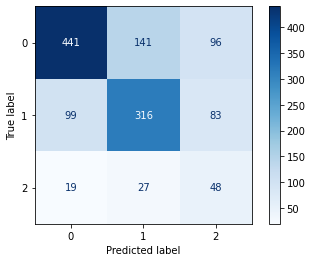

In [ ]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Second Model: Logistic Regression

In [ ]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_scaled,y_train)
y_pred2= model2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.79      0.59      0.67       678
           1       0.63      0.59      0.61       498
           2       0.16      0.50      0.25        94

    accuracy                           0.59      1270
   macro avg       0.53      0.56      0.51      1270
weighted avg       0.68      0.59      0.62      1270

0.5614493371716957
Kappa Score :
0.33442126701512376


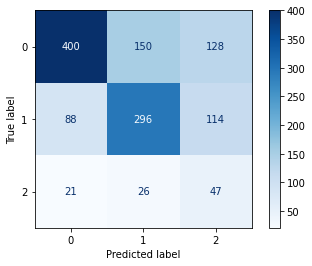

In [ ]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [ ]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_scaled,y_train)
y_pred3= model3.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.78      0.60      0.68       678
           1       0.62      0.62      0.62       498
           2       0.20      0.52      0.29        94

    accuracy                           0.60      1270
   macro avg       0.53      0.58      0.53      1270
weighted avg       0.67      0.60      0.63      1270

0.5809984430283741
Kappa Score :
0.3501198066848068


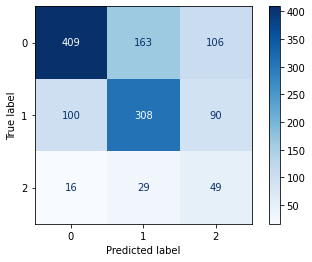

In [ ]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

In [ ]:
pickle.dump(model3, open('/content/drive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/SiftGBoost_model.sav', 'wb'))

Fourth Model: Random Forest Classifier

In [ ]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_scaled,y_train)
y_pred4= model4.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.79      0.66      0.72       678
           1       0.65      0.64      0.65       498
           2       0.22      0.52      0.31        94

    accuracy                           0.64      1270
   macro avg       0.56      0.61      0.56      1270
weighted avg       0.70      0.64      0.66      1270

0.6073990306295162
Kappa Score :
0.40286986210773446


In [ ]:
pickle.dump(model4, open('/content/drive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem/Models/WP_Aug/SiftRF_model.sav', 'wb'))

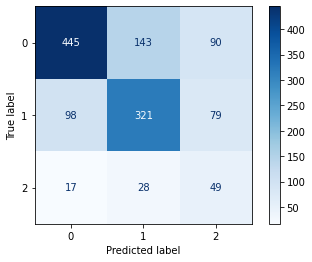

In [ ]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fifth model: AdaBoost classifier

In [ ]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_scaled,y_train)
y_pred5= model5.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.76      0.59      0.66       678
           1       0.60      0.59      0.60       498
           2       0.17      0.48      0.26        94

    accuracy                           0.58      1270
   macro avg       0.51      0.55      0.50      1270
weighted avg       0.65      0.58      0.61      1270

0.5520351663353344
Kappa Score :
0.31624699997575745


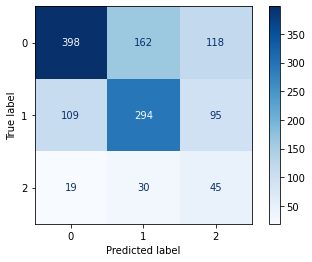

In [ ]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [ ]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_scaled,y_train)
y_pred6= model6.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.72      0.52      0.61       678
           1       0.56      0.48      0.52       498
           2       0.11      0.39      0.17        94

    accuracy                           0.50      1270
   macro avg       0.46      0.47      0.43      1270
weighted avg       0.61      0.50      0.54      1270

0.4670505281024935
Kappa Score :
0.21641993436830453


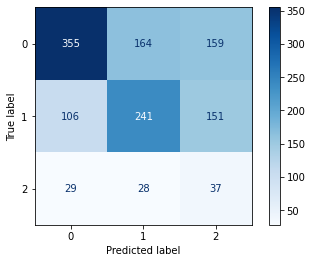

In [ ]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [ ]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_scaled,y_train)
y_pred7= model7.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.78      0.60      0.68       678
           1       0.61      0.62      0.62       498
           2       0.20      0.51      0.28        94

    accuracy                           0.60      1270
   macro avg       0.53      0.58      0.53      1270
weighted avg       0.67      0.60      0.62      1270

0.5774938075278583
Kappa Score :
0.3480783823595054


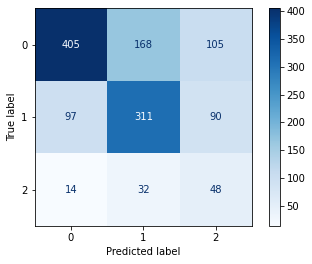

In [ ]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eigth model: Naive Bayes Classifier

In [ ]:
model8= GaussianNB()
model8.fit(X_train_scaled,y_train)
y_pred8= model8.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.74      0.54      0.62       678
           1       0.59      0.48      0.53       498
           2       0.14      0.53      0.22        94

    accuracy                           0.52      1270
   macro avg       0.49      0.52      0.46      1270
weighted avg       0.64      0.52      0.56      1270

0.5173968956854217
Kappa Score :
0.2493887859520716


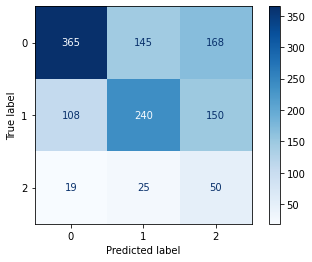

In [ ]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [ ]:
model9= KNeighborsClassifier()
model9.fit(X_train_scaled,y_train)
y_pred9= model9.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.77      0.67      0.72       678
           1       0.65      0.56      0.60       498
           2       0.22      0.60      0.33        94

    accuracy                           0.62      1270
   macro avg       0.55      0.61      0.55      1270
weighted avg       0.68      0.62      0.64      1270

0.6076870086257287
Kappa Score :
0.3715943481063857


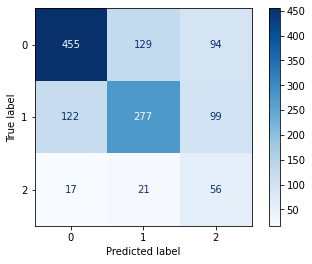

In [ ]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Tenth Model: Bagging Classifier

In [ ]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_scaled,y_train)
y_pred10= model10.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.79      0.65      0.71       678
           1       0.65      0.63      0.64       498
           2       0.22      0.53      0.32        94

    accuracy                           0.64      1270
   macro avg       0.55      0.61      0.56      1270
weighted avg       0.69      0.64      0.66      1270

0.6057680795358676
Kappa Score :
0.39449666258003


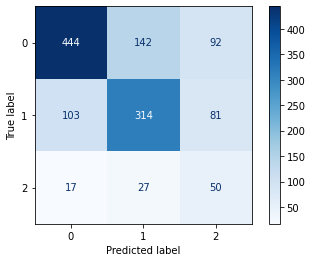

In [ ]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
model11=get_stack_model()
model11.fit(X_train_scaled,y_train)
y_pred11= model11.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))
print("Kappa Score :")
print(cohen_kappa_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.81      0.69      0.74       678
           1       0.68      0.67      0.68       498
           2       0.25      0.54      0.34        94

    accuracy                           0.67      1270
   macro avg       0.58      0.63      0.59      1270
weighted avg       0.72      0.67      0.69      1270

0.6330255434592194
Kappa Score :
0.44366335270533563


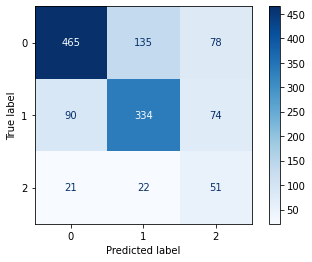

In [ ]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()